In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.chdir("/nas/ucb/oliveradk/diverse-gen/")


In [2]:
import json
from functools import partial
from itertools import product
from typing import Optional, Literal, Callable
from tqdm import tqdm
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from collections import defaultdict

import submitit
from submitit.core.utils import CommandFunction
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from losses.loss_types import LossType
from utils.exp_utils import get_executor, get_executor_local, run_experiments, get_conf_dir
from utils.proc_data_utils import get_exp_metrics, get_max_acc, get_acc_results
from utils.utils import conf_to_args

In [3]:
SCRIPT_NAME = "spur_corr_exp.py"
EXP_DIR = Path("output/cc_mix_rate_sweep_all") # output/cc_mix_rate_sweep_all"
# NOTE this is new
SUB_DIR = "2025-02-10_07-53-12" 
if SUB_DIR is None:
    SUB_DIR = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
EXP_DIR = Path(EXP_DIR, SUB_DIR)

EXP_DIR.mkdir(parents=True, exist_ok=True)

# Define Configs

In [4]:
# seeds
SEEDS = [1, 2, 3]

# mix rates
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]

# methods 
methods = {
    "DivDis": {"loss_type": LossType.DIVDIS},
    "TopK 0.1": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.1, "binary": True}, 
    "TopK 0.5": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.5, "binary": True}, 
    # "TopK 1.0": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 1.0}, 
    "DBAT": {"loss_type": LossType.DBAT, "shared_backbone": False, "freeze_heads": True, "binary": True},
    "ERM": {"loss_type": LossType.ERM, "binary": True},
}
# datasets 
datasets = {
    "toy_grid": {"dataset": "toy_grid", "model": "toy_model", "epochs": 100, "weight_decay": 1e-2, "batch_size": 32, "target_batch_size": 128, "plot_activations": False},
}

# tuned according to total validation loss
aux_weight_map = {
    "TopK 0.1": {
        "toy_grid": 1.0
    },
    "TopK 0.5": {
        "toy_grid": 1.0
    },
    "DivDis": {
        "toy_grid": 1.0,
    }, 
    "DBAT": {
        "toy_grid": 0.4,
    }, 
    "ERM": {
        "toy_grid": 0.0,
    }
}

lr_optim_map = {
    "TopK 0.1": {
        "toy_grid": (1e-3, "sgd")
    }, 
    "TopK 0.5": {
        "toy_grid": (1e-3, "sgd")
    },
    "DivDis": {
        "toy_grid": (1e-3, "adamw")
    }
}

configs = {
    (ds_name, method_name, mix_rate, seed): {**ds, **method, "mix_rate": mix_rate, "seed": seed} 
    for (ds_name, ds), (method_name, method), mix_rate, seed in product(datasets.items(), methods.items(), MIX_RATES, SEEDS)
    if method_name != "ERM"
}

erm_configs = {
    (ds_name, "ERM", 0.0, seed): {**ds, **methods["ERM"], "mix_rate": 0.0, "seed": seed}
    for (ds_name, ds), seed in product(datasets.items(), SEEDS)
}
configs = {**configs, **erm_configs}

###  dataset x method adjustments
# aux weight
for ((ds_name, method_name, mix_rate, seed), conf) in configs.items():
    conf["aux_weight"] = aux_weight_map[method_name][ds_name]
# optimizer and lr
for ((ds_name, method_name, mix_rate, seed), conf) in configs.items():
    if method_name in lr_optim_map and ds_name in lr_optim_map[method_name]:
        conf["lr"], conf["optimizer"] = lr_optim_map[method_name][ds_name]


for conf in configs.values():
    if conf["loss_type"] == LossType.DBAT: 
        conf["batch_size"] = int(conf["batch_size"] / 2)
        conf["target_batch_size"] = int(conf["target_batch_size"] / 2)


for conf_name, conf in configs.items():
    conf["exp_dir"] = get_conf_dir(conf_name, EXP_DIR)


In [5]:
len(configs)

63

# Run Experiments

In [8]:
high_mem_ds = ["multi-nli", "celebA-0"]
low_mem_configs = {k: v for k, v in configs.items() if v["dataset"] not in high_mem_ds}
high_mem_configs = {k: v for k, v in configs.items() if v["dataset"] in high_mem_ds}


In [9]:
executor = get_executor(EXP_DIR, mem_gb=16)
jobs = run_experiments(executor, list(low_mem_configs.values()), SCRIPT_NAME)


# Process Results

In [6]:
# TODO: condition on perfect source validation accuracy in model selection

In [7]:
def to_df(results: dict[dict]): 
    # Create a list to store flattened data
    flattened_data = []

    # Iterate through the nested structure
    for dataset, method_dict in results.items():
        for method, mix_rate_dict in method_dict.items():
            for mix_rate, accuracies in mix_rate_dict.items():
                # For each accuracy value in the list
                for acc in accuracies:
                    flattened_data.append({
                        'Dataset': dataset,
                        'Method': method,
                        'Mix_Rate': mix_rate,
                        'Accuracy': acc
                    })

    # Create DataFrame
    df = pd.DataFrame(flattened_data)
    df.sort_values(['Dataset', 'Method', 'Mix_Rate'], inplace=True)
    return df 

In [25]:
from typing import Literal, Optional
from pathlib import Path
import json 
from collections import defaultdict

import numpy as np

from losses.loss_types import LossType

def get_exp_metrics(conf: dict):
    if not (Path(conf["exp_dir"]) / "metrics.json").exists():
        raise FileNotFoundError(f"Metrics file not found for experiment {conf['exp_dir']}")
    with open(Path(conf["exp_dir"]) / "metrics.json", "r") as f:
        exp_metrics = json.load(f)
    return exp_metrics


def get_max_acc(
    exp_metrics: dict,
    acc_metric: str = "test_acc",
    model_selection: str = "val_loss",
    head_1_epochs: Optional[int] = None, 
    max_model_select: bool = False,
    one_head: bool = False, 
    mask: Optional[np.ndarray] = None
):
    if head_1_epochs is not None:
        exp_metrics = {k: v[head_1_epochs:] for k, v in exp_metrics.items()}
        mask = mask[head_1_epochs:]
    max_accs = np.array(exp_metrics[f'{acc_metric}_0'])
    if not one_head:
        max_accs = np.maximum(max_accs, np.array(exp_metrics[f'{acc_metric}_1']))
    selection_metric = exp_metrics[model_selection]
    if mask is not None:
        selection_metric = np.where(mask, selection_metric, np.inf if not max_model_select else -np.inf)
    if max_model_select: 
        max_acc_idx = np.argmax(selection_metric)
    else: 
        max_acc_idx = np.argmin(selection_metric)
    max_acc = max_accs[max_acc_idx]
    return max_acc



# TODO: fix edge case with dbat and mask (100 - 50)
# data structure: dictionary with keys method types, values dict[mix_rate, list[len(seeds)]] of cifar accuracies (for now ignore case where mix_rate != mix_rate_lower_bound)
def get_acc_results(
    exp_configs: list[dict],
    acc_metric: Literal["test_acc", "test_worst_acc", "test_acc_alt"]="test_acc",
    model_selection: Literal["acc", "loss", "weighted_loss", "repulsion_loss"]="acc",
    verbose: bool=False, 
    mix_rates: bool = True, 
    perf_source_acc: bool = False
) -> dict | list:
    if mix_rates:
        results = defaultdict(list)
    else:
        results = []
    for conf in exp_configs:
        try:
            exp_metrics = get_exp_metrics(conf)
            head_1_epochs = round(conf["epochs"] / 2) if conf.get("loss_type", None) == LossType.DBAT else None
            # condition on perfect source validation accuracy in model selection
            mask = None 
            if perf_source_acc:
                head_0_acc = np.maximum(exp_metrics["val_source_acc_0"], exp_metrics["val_source_acc_alt_0"])
                head_1_acc = np.maximum(exp_metrics["val_source_acc_1"], exp_metrics["val_source_acc_alt_1"])
                mask = (head_0_acc == 1.0) & (head_1_acc == 1.0)
                # check if mask is all false 
                if not np.any(mask):
                    mask = None
            
            max_acc = get_max_acc(exp_metrics, 
                acc_metric=acc_metric, 
                model_selection=model_selection, 
                head_1_epochs=head_1_epochs, 
                mask=mask
            )
            if mix_rates:
                results[conf.get("mix_rate", 0.0)].append(max_acc)
            else:
                results.append(max_acc)
        except FileNotFoundError:
            if verbose:
                print(f"Metrics file not found for experiment {conf['exp_dir']}")
            continue
    if mix_rates:
        results = dict(results)
    return results

In [26]:
# sort experiments
exps_by_dataset_method = defaultdict(lambda:defaultdict(list))
for (ds_name, method_name, mix_rate, seed), conf in configs.items():
    exps_by_dataset_method[ds_name][method_name].append(conf)

In [35]:
# get average accs (by val loss) for each experiment
acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        acc_results[ds_name][method_name] = get_acc_results(
            exps, model_selection="val_loss", acc_metric="test_acc", verbose=True, perf_source_acc=True
        )

In [28]:
# get average accs (by val loss) for each experiment
alt_acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        alt_acc_results[ds_name][method_name] = get_acc_results(
            exps, model_selection="val_loss", acc_metric="test_acc_alt", perf_source_acc=True
        )

In [29]:
# get average accs (by val loss) for each experiment
worst_acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        worst_acc_results[ds_name][method_name] = get_acc_results(
            exps, model_selection="val_loss", acc_metric="test_worst_acc", perf_source_acc=True
        )

In [30]:
source_acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        source_acc_results[ds_name][method_name] = get_acc_results(
            exps, model_selection="val_loss", acc_metric="val_source_acc", perf_source_acc=True
        )

In [36]:
# load into dataframe
acc_result_df = to_df(acc_results)
alt_acc_result_df = to_df(alt_acc_results)
worst_acc_result_df = to_df(worst_acc_results)
source_acc_result_df = to_df(source_acc_results)

acc_result_df.to_csv(f"results/cc_mix_rate_acc.csv", index=False)
alt_acc_result_df.to_csv(f"results/cc_mix_rate_alt_acc.csv", index=False)
worst_acc_result_df.to_csv(f"results/cc_mix_rate_worst_acc.csv", index=False)
source_acc_result_df.to_csv(f"results/cc_mix_rate_source_acc.csv", index=False)


## Plot Accuracy

In [32]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10
ignored_loss_types = []


In [37]:
def plot_acc_results_grid(
    results_dict: dict,
    nrows: int = 2,
    ncols: int = 3,
    ignored_loss_types: list[str] = [],
    figsize: tuple[float, float] = (9, 6),
    ylim: tuple[float, float] = (0.5, 1.0),
    fontsize: int = FONTSIZE,
    tick_fontsize: int = TICK_FONTSIZE,
    xlabel: str = "Mix Rate",
    ylabel: str = "Accuracy",
    dataset_titles: dict[str, str] = {},
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, (ds_name, method_dict) in enumerate(results_dict.items()):
        ax = axes[idx]
        
        for loss_type, loss_results in method_dict.items():
            if loss_type in ignored_loss_types:
                continue
            
            if isinstance(loss_type, LossType):
                loss_type = loss_type.name 
            
            if loss_type == LossType.ERM.name:
                results = [r for result in loss_results.values() for r in result]
                means = [np.mean(results) for _ in range(len(MIX_RATES))]
                stds = [np.std(results) for _ in range(len(MIX_RATES))]
                line_style = '--'
                marker = None
            else:
                means = [np.mean(loss_results[mix_rate]) for mix_rate in MIX_RATES]
                stds = [np.std(loss_results[mix_rate]) for mix_rate in MIX_RATES]
                line_style = '-'
                marker = 'o'
            
            ax.plot(MIX_RATES, means, label=loss_type, marker=marker, linestyle=line_style)
            ax.fill_between(MIX_RATES, 
                          [m - s for m, s in zip(means, stds)],
                          [m + s for m, s in zip(means, stds)],
                          alpha=0.2)

        x_labels = [str(mix_rate) for mix_rate in MIX_RATES]
        ax.set_xticks(MIX_RATES)
        ax.set_xticklabels(x_labels, fontsize=tick_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        title = dataset_titles.get(ds_name, ds_name) if dataset_titles else ds_name
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylim(*ylim)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a single legend for the entire figure
    handles, labels = axes[0].get_lines(), [line.get_label() for line in axes[0].get_lines()]
    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=len(methods))

    fig.supxlabel(xlabel, fontsize=fontsize)
    fig.supylabel(ylabel, fontsize=fontsize)
    
    fig.tight_layout()
    return fig, axes

dataset_titles = {
    "toy_grid": "Toy Grid",
    "fmnist_mnist": "FMNIST+MNIST",
    "cifar_mnist": "CIFAR+MNIST",
    "waterbirds": "Waterbirds",
    "celebA-0": "CelebA",
    "multi-nli": "MultiNLI"
}

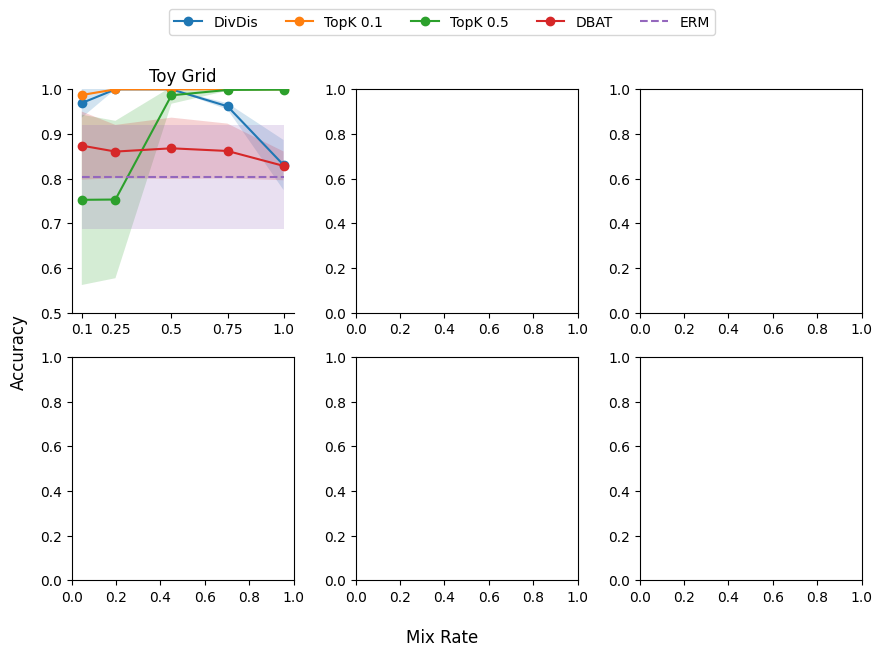

In [38]:
fig, axes = plot_acc_results_grid(acc_results, ignored_loss_types=ignored_loss_types, dataset_titles=dataset_titles)
fig.savefig("figures/cc_mix_rate.svg", bbox_inches="tight", dpi=300)
plt.show()


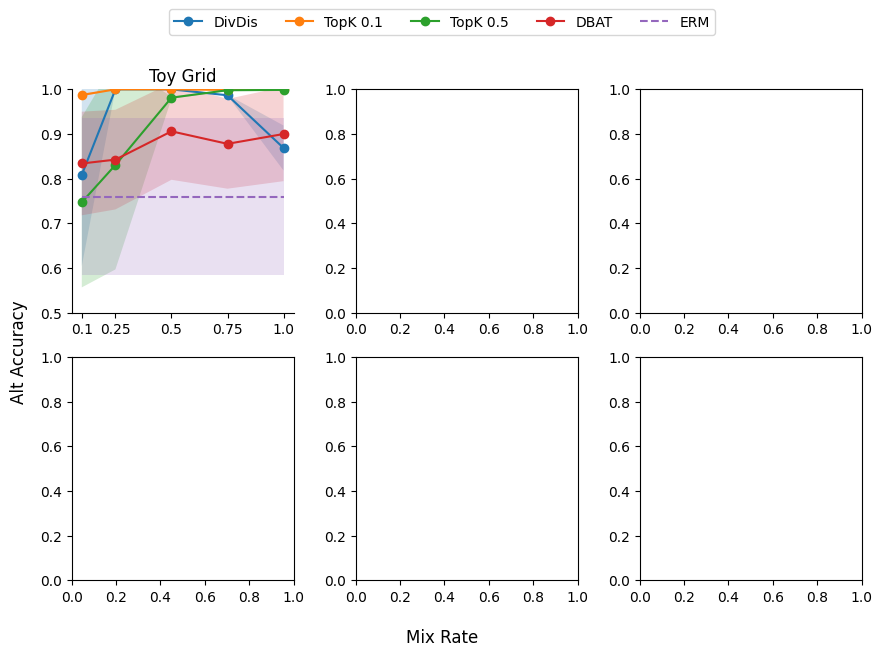

In [39]:

fig, axes = plot_acc_results_grid(alt_acc_results, ignored_loss_types=ignored_loss_types, 
                      dataset_titles=dataset_titles, ylabel="Alt Accuracy")
fig.savefig("figures/cc_mix_rate_alt.svg", bbox_inches="tight", dpi=300)
plt.show()

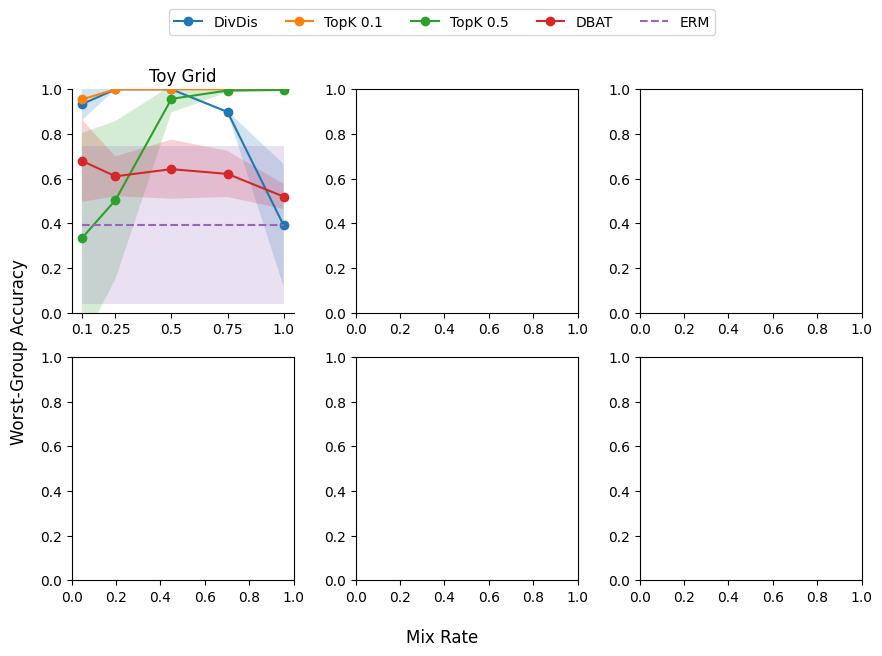

In [40]:

fig, axes = plot_acc_results_grid(worst_acc_results, 
                      ignored_loss_types=ignored_loss_types, ylim=(0.0, 1.0), 
                      dataset_titles=dataset_titles, 
                      ylabel="Worst-Group Accuracy")

fig.savefig("figures/cc_mix_rate_worst.svg", bbox_inches="tight", dpi=300)
plt.show()


## Plot Aggregate Metrics Across Datasets 

In [34]:
def plot_aggregate_metrics(
    acc_results: dict,
    alt_acc_results: dict,
    worst_acc_results: dict,
    included_methods: list[str] = [],
    figsize: tuple[float, float] = (15, 5),
    save_path: Optional[str] = None,
    use_quartiles: bool = False
):
    # Create a function to aggregate results and compute differences from ERM
    def aggregate_results(results_dict):
        all_results = []
        
        # First get ERM baseline for each dataset
        erm_baselines = {}
        for dataset, method_dict in results_dict.items():
            if "ERM" in method_dict:
                # Combine all ERM results for this dataset
                all_erm_accs = [acc for mix_rate_accs in method_dict["ERM"].values() 
                              for acc in mix_rate_accs]
                erm_baselines[dataset] = np.mean(all_erm_accs)
        
        # Then compute differences for each method
        for dataset, method_dict in results_dict.items():
            erm_baseline = erm_baselines.get(dataset, 0)
            for method, mix_rate_dict in method_dict.items():
                if method not in included_methods:
                    continue
                    
                for mix_rate, accuracies in mix_rate_dict.items():
                    mean_acc = np.mean(accuracies)
                    # Compute difference from ERM baseline
                    acc_diff = mean_acc - erm_baseline
                    all_results.append({
                        'Dataset': dataset,
                        'Method': method,
                        'Mix_Rate': mix_rate,
                        'Accuracy_Diff': acc_diff
                    })
        return pd.DataFrame(all_results)

    # Create dataframes for each metric
    acc_df = aggregate_results(acc_results)
    alt_df = aggregate_results(alt_acc_results)
    worst_df = aggregate_results(worst_acc_results)

    # Add metric type to each dataframe
    acc_df['Metric'] = 'Average'
    alt_df['Metric'] = 'Alternate'
    worst_df['Metric'] = 'Worst-Group'

    # Combine all dataframes
    combined_df = pd.concat([acc_df, alt_df, worst_df])

    # Calculate statistics across datasets
    if use_quartiles:
        summary_df = combined_df.groupby(['Method', 'Mix_Rate', 'Metric'])['Accuracy_Diff'].agg([
            ('median', 'median'),
            ('q25', lambda x: x.quantile(0.25)),
            ('q75', lambda x: x.quantile(0.75))
        ]).reset_index()
    else:
        summary_df = combined_df.groupby(['Method', 'Mix_Rate', 'Metric'])['Accuracy_Diff'].agg([
            ('mean', 'mean'),
            ('std', 'std')
        ]).reset_index()

    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    metrics = ['Average', 'Alternate', 'Worst-Group']

    # Set symmetric y-limits centered on 0
    max_abs_val = max(abs(summary_df['mean' if not use_quartiles else 'median'].min()),
                     abs(summary_df['mean' if not use_quartiles else 'median'].max()))
    ylim = (-0.1, 1.0)
    
    for ax in axes[:2]:  # Only set for first two plots
        ax.set_ylim(ylim)

    for idx, metric in enumerate(metrics):
        metric_data = summary_df[summary_df['Metric'] == metric]
        
        # Calculate bar positions
        mix_rates = MIX_RATES
        methods = [m for m in metric_data['Method'].unique() if m in included_methods]
        x = np.arange(len(mix_rates))
        width = 0.15  # Width of bars
        
        # Plot bars for each method
        for i, method in enumerate(methods):
            method_data = metric_data[metric_data['Method'] == method]
            
            medians = []
            errors_lower = []
            errors_upper = []
            
            for mix_rate in mix_rates:
                data = method_data[method_data['Mix_Rate'] == mix_rate]
                if len(data) > 0:
                    if use_quartiles:
                        median = data['median'].iloc[0]
                        q25 = data['q25'].iloc[0]
                        q75 = data['q75'].iloc[0]
                        medians.append(median)
                        errors_lower.append(median - q25)
                        errors_upper.append(q75 - median)
                    else:
                        mean = data['mean'].iloc[0]
                        std = data['std'].iloc[0]
                        medians.append(mean)
                        errors_lower.append(std)
                        errors_upper.append(std)
                else:
                    medians.append(np.nan)
                    errors_lower.append(np.nan)
                    errors_upper.append(np.nan)
            
            offset = width * (i - len(methods)/2 + 0.5)
            
            if use_quartiles:
                yerr = np.array([errors_lower, errors_upper])
            else:
                yerr = errors_lower
                
            axes[idx].bar(x + offset, medians, width, label=method,
                         yerr=yerr, capsize=3)
            
            # Add horizontal line at y=0
            axes[idx].axhline(y=0, color='black', linestyle='-', alpha=0.2)
        
        stat_type = "Median" if use_quartiles else "Mean"
        axes[idx].set_title(f'{metric}')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels([f'{mr:.2f}' for mr in mix_rates], rotation=45)
        axes[idx].spines['top'].set_visible(False)
        axes[idx].spines['right'].set_visible(False)
        if idx == 0:
            axes[idx].set_ylabel('Accuracy Difference from ERM')
        axes[idx].set_xlabel('Mix Rate')

    # Add legend to the first subplot
    axes[0].legend(bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=len(methods))

    plt.tight_layout()
    
    if save_path:
        base, ext = os.path.splitext(save_path)
        stat_type = "_quartiles" if use_quartiles else "_meanstd"
        new_save_path = f"{base}{stat_type}{ext}"
        plt.savefig(new_save_path, bbox_inches="tight", dpi=300)
    
    plt.show()
    
    return fig, axes

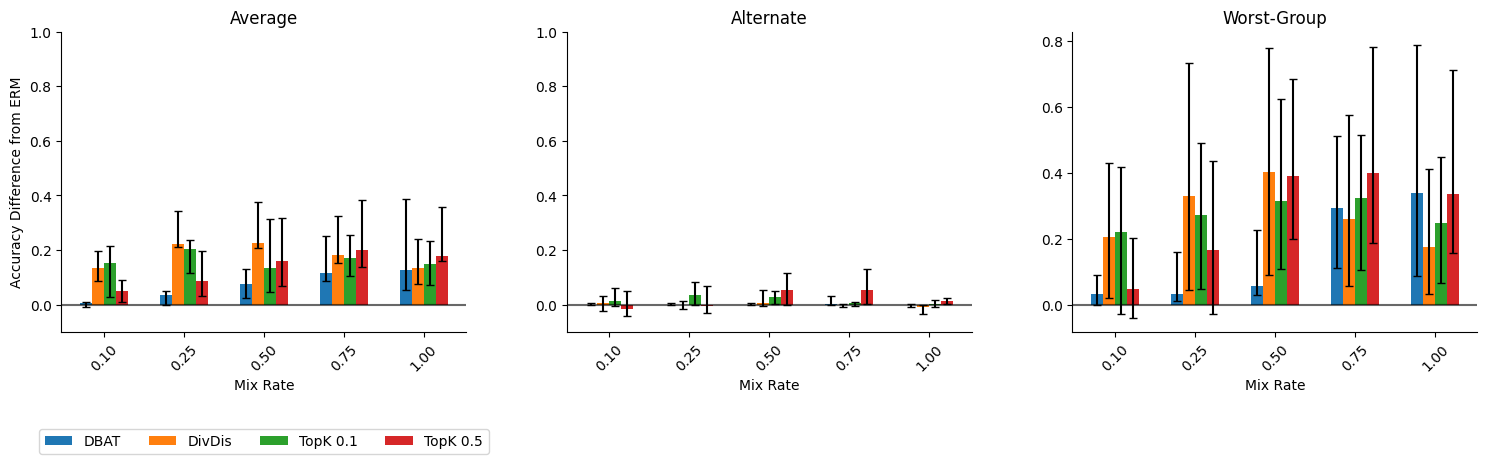

In [35]:
# Example usage:
# ignored_methods = ["DBAT", "ERM"]  # Methods to filter out
fig, axes = plot_aggregate_metrics(
    acc_results,
    alt_acc_results,
    worst_acc_results,
    included_methods=["TopK 0.5", "DivDis", "TopK 0.1", "DBAT"],
    save_path="figures/cc_mix_rate_summary_divdis_topk.svg", 
    use_quartiles=True
)

# Plot Correlation Between Val Loss, Val Acc, Test Acc

In [36]:
def plot_metric_correlations(configs, figsize=(15, 4), normalize=True, min_val_loss_only=False, mix_rate_color=False):
    # Group configs by method
    methods_configs = defaultdict(dict)
    for k, v in configs.items():
        method = k[1]  # Get method from config key
        methods_configs[method][k] = v
    
    # Create figure with subplots in one row
    n_methods = len(methods_configs)
    fig, axes = plt.subplots(1, n_methods, figsize=figsize)
    if n_methods == 1:
        axes = np.array([axes])
    
    # Process each method's data
    for idx, (method, method_configs) in enumerate(methods_configs.items()):
        # Collect metrics for this method
        all_metrics = []
        for conf in method_configs.values():
            metrics = get_exp_metrics(conf)
            if metrics is not None:
                # Get max accuracy between heads
                val_acc = np.array(metrics["val_target_acc_0"])
                if "val_target_acc_1" in metrics:
                    val_acc = np.max([val_acc, np.array(metrics["val_target_acc_1"])], axis=0)
                test_acc = np.array(metrics["test_acc_0"])
                if "test_acc_1" in metrics:
                    test_acc = np.max([test_acc, np.array(metrics["test_acc_1"])], axis=0)
                
                assert val_acc.shape == test_acc.shape
                
                if min_val_loss_only:
                    min_val_loss_idx = np.argmin(metrics["val_loss"])
                    all_metrics.append({
                        'val_loss': metrics["val_loss"][min_val_loss_idx],
                        'val_acc': val_acc[min_val_loss_idx],
                        'test_acc': test_acc[min_val_loss_idx],
                        'dataset': conf["dataset"],
                        'mix_rate': conf["mix_rate"]
                    })
                else:
                    for i in range(val_acc.shape[0]):
                        all_metrics.append({
                            'val_loss': metrics["val_loss"][i],
                            'val_acc': val_acc[i],
                            'test_acc': test_acc[i],
                            'dataset': conf["dataset"],
                            'mix_rate': conf["mix_rate"]
                        })
        
        df = pd.DataFrame(all_metrics)
        
        if normalize and not df.empty:
            for metric in ['val_loss', 'val_acc', 'test_acc']:
                groups = df.groupby(['dataset', 'mix_rate'])
                normalized = groups[metric].transform(lambda x: (x - x.mean()) / x.std())
                df[metric] = normalized
        
        if not df.empty:
            # Plot correlations
            ax = axes[idx]
            c = df['mix_rate'] if mix_rate_color else None
            cmap = 'viridis' if mix_rate_color else None
            scatter = ax.scatter(df['val_loss'], df['test_acc'], 
                               c=c, cmap=cmap, 
                               alpha=0.5)
            
            # Only add colorbar to last subplot
            if idx == n_methods - 1 and mix_rate_color:
                plt.colorbar(scatter, ax=ax, label='Mix Rate')
            
            # Only add y-label to first subplot
            if idx == 0:
                ax.set_ylabel('Test Accuracy (Normalized)' if normalize else 'Test Accuracy')
            
            # Add x-label to all subplots
            ax.set_xlabel('Validation Loss (Normalized)' if normalize else 'Validation Loss')
            
            r = np.corrcoef(df["val_loss"], df["test_acc"])[0,1]
            ax.set_title(f'{method}\nr={r:.3f}')
            
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if normalize:
                ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
                ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig, axes

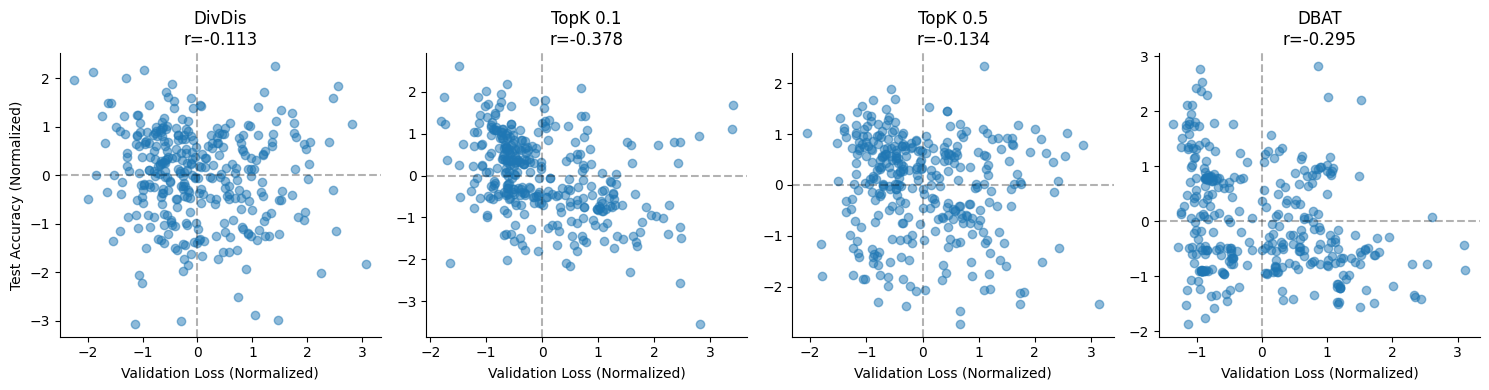

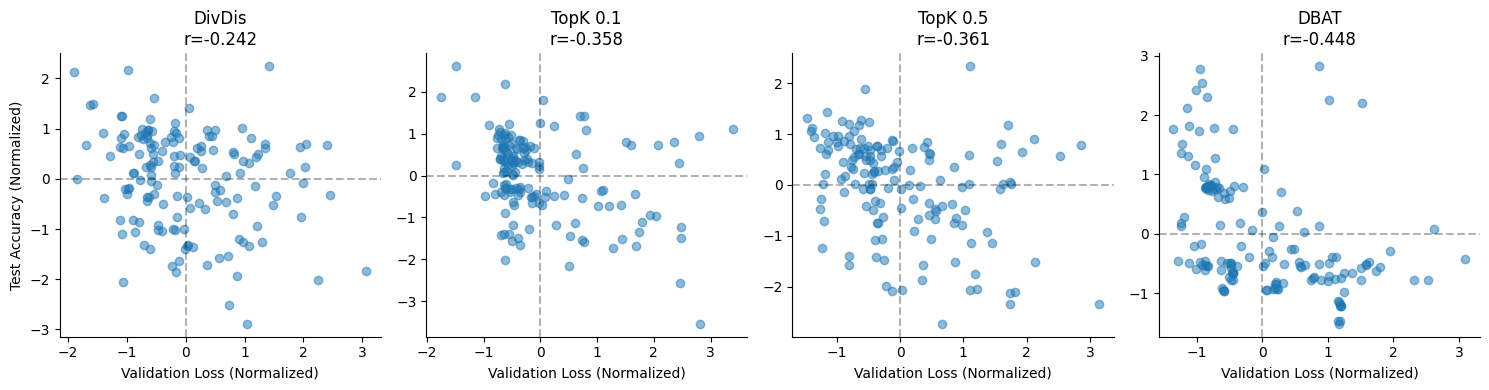

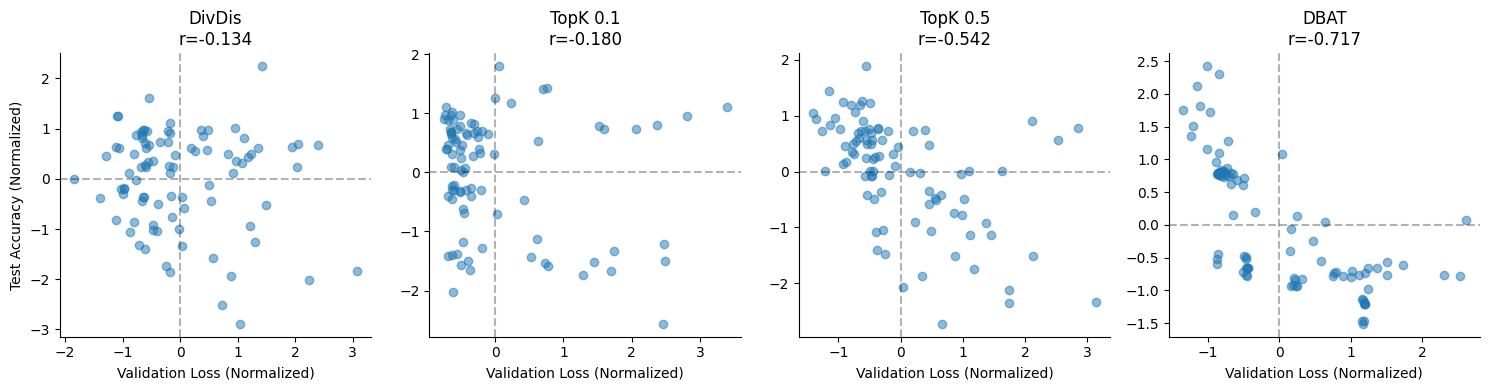

In [37]:
configs_to_plot = {k: v for k, v in configs.items() 
    if v["dataset"] != "toy_grid" and 
    v["loss_type"].name != "ERM"
}
fig, axes = plot_metric_correlations(configs_to_plot, normalize=True, min_val_loss_only=False)
fig.savefig("figures/cc_metric_corrs/cc_metric_correlations_all.svg", bbox_inches="tight", dpi=300)
plt.show()

configs_to_plot = {k: v for k, v in configs.items() 
    if v["dataset"] not in ["multi-nli", "celebA-0", "waterbirds", "toy_grid"] and 
    v["loss_type"].name != "ERM"
}
fig, axes = plot_metric_correlations(configs_to_plot, normalize=True, min_val_loss_only=False)
fig.savefig("figures/cc_metric_corrs/cc_metric_correlations_all_proportional.svg", bbox_inches="tight", dpi=300)
plt.show()

configs_to_plot = {k: v for k, v in configs.items() 
    if v["dataset"] not in ["multi-nli", "celebA-0", "waterbirds", "toy_grid"] 
    and v["mix_rate"] >= 0.5 and 
    v["loss_type"].name != "ERM"
}
fig, axes = plot_metric_correlations(configs_to_plot, normalize=True, min_val_loss_only=False)
fig.savefig("figures/cc_metric_corrs/cc_metric_correlations_all_proportional_mix_rate_0_5.svg", bbox_inches="tight", dpi=300)
plt.show()
